In [1]:
from __future__ import annotations
import pandas as pd ; import os ; import numpy as np ; import matplotlib.pyplot as plt ; from math import sqrt
import matplotlib as mpl

main_path = r'./'
# if not os.path.exists(os.path.join(main_path)):
#     os.makedirs(os.path.join(main_path))
# df_data = pd.read_excel(os.path.join(main_path, 'Bitcoin Paper Datasheet.xlsx'), engine='openpyxl',
#                         sheet_name='Turning Point')

# df_hardware, df_date = df_data['Hardware (TH/J)'].dropna(), df_data['Date'].dropna()


In [2]:
import pandas as pd

# Load the data
monthly_stuff = pd.read_csv('../6_calculating_costs/monthly_stuff.csv', parse_dates=['date'],usecols=['date', 'efficiency'])

# keep only rows after 2012
# monthly_stuff = monthly_stuff[monthly_stuff['date'].dt.year >= 2012]

# keep only rows before 2013-07-01
# monthly_stuff = monthly_stuff[monthly_stuff['date'] < '2013-07-01']
monthly_stuff = monthly_stuff[monthly_stuff['date'] > '2011-02-01']

# quarterly average
from datetime import timedelta
monthly_stuff['quarter'] = (monthly_stuff['date'] - timedelta(days=45)).dt.to_period('Q')
quarterly_data = monthly_stuff.groupby('quarter')['efficiency'].mean().reset_index()
quarterly_data['quarter'] = quarterly_data['quarter'].dt.to_timestamp()


# Set the 'date' column as the index
quarterly_data.set_index('quarter', inplace=True)

# Resample the data to daily frequency, creating NaN values for new days
daily_data = quarterly_data.resample('D').asfreq()

# Interpolate the missing data points
daily_data_interpolated = daily_data.interpolate(method='linear')  # You can also use other methods like 'time' or 'spline'

# Reset the index if you want the date back as a column
daily_data_interpolated.reset_index(inplace=True)

In [3]:
daily_data_interpolated

,quarter,efficiency
0,2011-01-01,1.595937e+06
1,2011-01-02,1.597838e+06
2,2011-01-03,1.599739e+06
3,2011-01-04,1.601640e+06
4,2011-01-05,1.603541e+06
...,...,...
4560,2023-06-27,2.289592e+10
4561,2023-06-28,2.293476e+10
4562,2023-06-29,2.297360e+10
4563,2023-06-30,2.301244e+10


In [4]:
df = daily_data_interpolated.rename(columns={'quarter': 'Date', 'efficiency': 'Hardware (TH/J)'})
df_hardware, df_date = df['Hardware (TH/J)'], df['Date']

Turning point on row: 912 which is date: 2013-07-01 00:00:00 at 635939047.4609677 TH/J


C:\Users\Timothe\AppData\Local\Temp\ipykernel_8488\3487475193.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.plot(simpli_x[int(idx)], simpli_y[int(idx)], 'ko', markersize=3, label='Turning point')


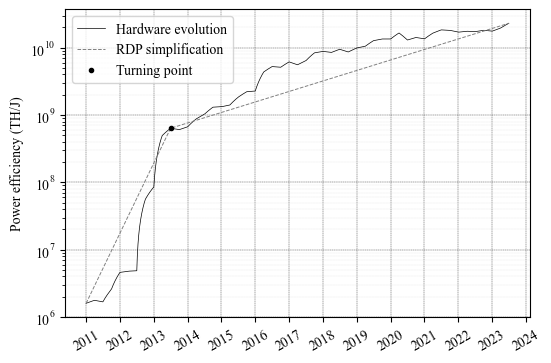

In [5]:
count_row_date, count_row_hardware = df_date.shape[0], df_hardware.shape[0]
if count_row_date != count_row_hardware: df_hardware = df_hardware.iloc[:-(count_row_hardware - count_row_date)]
df_hardware = np.log10(df_hardware)

def point_line_distance(point, start, end):
    if start == end: return sqrt((point[0] - start[0]) ** 2 + (point[1] - start[1]) ** 2)
    else:
        n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
        d = sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        return n / d

def ramer_douglas_peucker(points, epsilon):
    """
    Ramer–Douglas–Peucker algorithm (Ramer 1972, Douglas & Peucker 1973)
    Adapted from http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm and https://github.com/sebleier/RDP/
    Reduces a series of points to a simplified version that loses detail, but maintains the general shape of the series.
    - points is a 2D-array of shape (N,M) with x-axis and y-axis values
    - epsilon (ε) is the tolerance of the algorithm. If the point is closer than ε to the line segment, then any points
    not currently marked to be kept can be discarded without the simplified curve being worse than ε.
    If the point farthest from the line segment is greater than ε from the approximation then that point must be kept.
    """
    dmax = 0.0 ; index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax: index = i ; dmax = d
    if dmax >= epsilon:
        results = ramer_douglas_peucker(points[:index+1], epsilon)[:-1] + ramer_douglas_peucker(points[index:], epsilon)
    else: results = [points[0], points[-1]]
    return results

def angle(dir):
    """
    Returns the angles between vectors.
    - dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.
    - The return value is a 1D-array of values of shape (N-1,), with each value between 0 and pi.
    0 implies the vectors point in the same direction, pi/2 implies orthogonal, pi implies opposite directions
    """
    dir2 = dir[1:] ; dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

''' Ramer–Douglas–Peucker algorithm (Ramer 1972, Douglas & Peucker 1973) '''

# set arbitrarily to find only one turning point
tolerance = 1.3 
tolerance = 1.1

min_angle = 0.0 ; number_days_list = list(range(count_row_date))
points = list(zip(number_days_list, df_hardware))
simplified = np.array(ramer_douglas_peucker(points, tolerance)) # x, y coordinates of points that are turning points
directions = np.diff(simplified, axis=0) ; theta = angle(directions) ; idx = np.where(theta>min_angle)[0]+1

''' Plotting the figure with turning point '''
plt.rcParams["font.family"] = "Times New Roman"
x, y = df_date, [10 ** y for y in df_hardware] ; simpli_x, simpli_y = simplified.T ; turn_point_row = int(simpli_x[1])
simpli_x, simpli_y = [df_date[simpli_x[d]] for d in range(len(simpli_x))], [10 ** y for y in simpli_y]
print('Turning point on row:', turn_point_row, 'which is date:', simpli_x[1], 'at', simpli_y[1], 'TH/J')

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, 'k-', linewidth=0.5, label='Hardware evolution')
ax.plot(simpli_x, simpli_y, c='0.5', linewidth=0.7, linestyle='dashed', label='RDP simplification')
ax.plot(simpli_x[int(idx)], simpli_y[int(idx)], 'ko', markersize=3, label='Turning point')
# plt.ylim(10**(int(np.log10(np.min(y))) - 1), 10**(int(np.log10(np.max(y)))))
# plt.xlim(min(x), max(x))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(mpl.dates.YearLocator(base=1)) ; ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
ax.set_yscale('log') ; plt.ylabel('Power efficiency (TH/J)') ; plt.legend(loc='best')
ax.xaxis.grid(True,'minor', linestyle='--', linewidth=0.1)
ax.yaxis.grid(True,'minor', linestyle='--', linewidth=0.1)
ax.xaxis.grid(True,'major', linestyle='--', linewidth=0.25, color='k')
ax.yaxis.grid(True,'major', linestyle='--', linewidth=0.25, color='k')
# plt.show()
# fig.savefig(os.path.join(main_path, 'TurningPoint_tol_ ' + str(tolerance) + '.png'), bbox_inches='tight', dpi=600)

# ''' Plotting the hashrate on the same plot (but in small) '''
# df_hashrate, df_date = df_data['Hashrate (TH/s)'].dropna(), df_data['Date'].dropna()
# count_row_date, count_row_hashrate = df_date.shape[0], df_hashrate.shape[0]
# if count_row_date != count_row_hashrate: df_hashrate = df_hashrate.iloc[:-(count_row_hashrate - count_row_date)]

# left, bottom, width, height = [0.567, 0.222, 0.3, 0.35]
# ax_hashrate = fig.add_axes([left, bottom, width, height])
# ax_hashrate.plot(df_date, df_hashrate, 'k-', linewidth=0.3, label='Hardware evolution')
# ax_hashrate.set_ylim(10**(int(np.log10(np.min(df_hashrate))) + 2), 10**(int(np.log10(np.max(df_hashrate))) + 1))
# ax_hashrate.set_xlim(min(df_date), max(df_date)) ; ax_hashrate.tick_params(axis='x', labelrotation = 30)
# ax_hashrate.xaxis.set_major_locator(mpl.dates.YearLocator(base=2))
# ax_hashrate.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y"))
# ax_hashrate.plot(simpli_x[int(idx)], df_hashrate[turn_point_row], 'ko', markersize=3)
# ax_hashrate.set_yscale('log') ; ax_hashrate.set_ylabel('Hashrate (TH/s)')
# ax_hashrate.xaxis.grid(True,'minor', linestyle='--', linewidth=0.1)
# ax_hashrate.yaxis.grid(True,'minor', linestyle='--', linewidth=0.1)
# ax_hashrate.xaxis.grid(True,'major', linestyle='--', linewidth=0.25, color='k')
# ax_hashrate.yaxis.grid(True,'major', linestyle='--', linewidth=0.25, color='k')
plt.show()
fig.savefig(os.path.join(main_path, 'Hardware_Hashrate.png'), bbox_inches='tight', dpi=600)
